# Runoff ratios, Upper Cache Creek in Yolo Co.

https://water.usgs.gov/lookup/getwatershed?18020116

Runoff ratio is the ratio of precipitation to runoff. For a watershed, can we track change over time from stream gauge and precipitation data? Trends in runoff ratios may be an indication of overall soil function.

Streamflow gauges: mostly USGS

Precipitation: rainfall gauges, plus CHIRPS using Earth Engine: *Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a 30+ year quasi-global rainfall dataset. CHIRPS incorporates 0.05° resolution satellite imagery with in-situ station data to create gridded rainfall time series for trend analysis and seasonal drought monitoring.*

According to
http://www.ycfcwcd.org/infrastructure.html

Capay Diversion Dam diverts about 150,000 a-f on an average year. 

In [1]:
#basic imports
from climata.usgs import DailyValueIO
from climata.acis import StationDataIO
import hydrofunctions as hf
import datetime
import pandas as pd, numpy as np
import folium  #folium on Jupyter doesn't display well in Microsoft Edge. Chrome works.
import vincent, vega #for charting in popups
# vincent.core.initialize.notebook()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8] #gives size in inches to plots
%matplotlib inline


## Streamflow from NWIS



In [2]:
#this uses the climata library
huc8 = '18020116' #Upper Cache, Capay Valley
startdate = "1981-10-01"
enddate = "2019-03-28"
param_id = "00060" #streamflow
data = DailyValueIO(
    start_date=startdate,
    end_date=enddate,
    basin=huc8, #Upper Cache   
    parameter=param_id,
)
list(data)

[DailyValueIOTuple(site_name='KELSEY C NR KELSEYVILLE CA', site_code='11449500', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=38.92739984, longitude=-122.8436046, data=<climata.parsers.TimeSeriesIO object at 0x000001A10B4F1208>),
 DailyValueIOTuple(site_name='CACHE C NR LOWER LAKE CA', site_code='11451000', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=38.9240648, longitude=-122.5658147, data=<climata.parsers.TimeSeriesIO object at 0x000001A10B663E48>),
 DailyValueIOTuple(site_name='NF CACHE C A HOUGH SPRING NR CLEARLAKE OAKS CA', site_code='11451100', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=39.1654458, longitude=-122.6199862, data=<climata.parsers.TimeSeriesIO object at 0x000001A10B663E80>),
 DailyValueIOTuple(site_name='INDIAN VALLEY PH INTAKE NR CLEARLAKE OAKS CA', site_code='11451292', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3

In [3]:
#make dataframe of info for each site with nested list comprehension
fstations = pd.DataFrame([[y for y in x] for x in data], columns=['name','code','variable_name','variable_code','unit','lat','lon','data'])

In [4]:
m = folium.Map(location=[fstations['lat'].mean(), fstations['lon'].mean()], zoom_start=9, tiles="Stamen Terrain")
for i in range(0,len(fstations)):
    tooltip = fstations.iloc[i]['name']
    folium.Marker([fstations.iloc[i]['lat'], fstations.iloc[i]['lon']],tooltip=tooltip).add_to(m)

    
def huc8_borders(feature):
    return {
        'fillOpacity': 0,
        'weight': 2,
        'color':'red'
        }

def huc12_borders(feature):
    return {
        'fillOpacity': 0,
        'weight': 1,
        'color':'blue'
        }

# folium.TopoJson(
#     open('wbdhu12_a_oh_topo.json'), #path to file
#     'objects.wbdhu12_a_oh',
#     name='HUC12 boundaries',
#     style_function=huc12_borders,
#     ).add_to(m)

# folium.TopoJson(
#     open('ohio_huc8_topo.json'), #path to file
#     'objects.wbdhu8_a_oh',
#     name='HUC8 boundaries',
#     style_function=huc8_borders,
#     ).add_to(m)
    
m

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A10C762F98>,
      dtype=object)

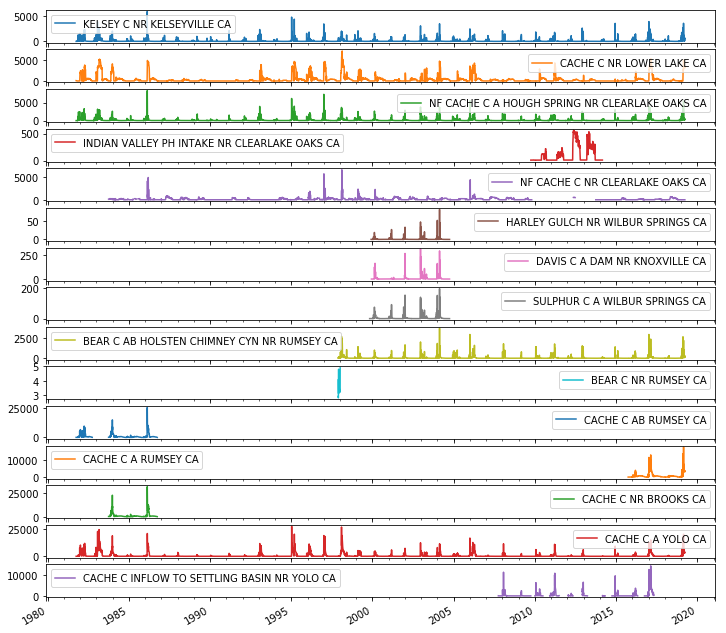

In [5]:
#make dataframe with datetime index for all flows
dtindex = pd.date_range(start=startdate, end=enddate)
df = pd.DataFrame(index=dtindex)
for i in range(0,len(data)):
    dates = [r[0] for r in data[i].data]
    flow = [r[1] for r in data[i].data]
    fs = pd.Series(data = flow, index=dates)
    df[data[i].site_name] = fs

df.plot(subplots=True, figsize=(12,12)) 
# d = group[data[1].site_name].dropna(0)

In [6]:
#make dataframe from Yolo, Lower Lake
yolo = DailyValueIO(
    start_date=startdate,
    end_date=enddate,
    station="11452500",
    parameter="00060"
)
lowerlake = DailyValueIO(
    start_date=startdate,
    end_date=enddate,
    station="11451000",
    parameter="00060"
)


In [7]:
#after some inspection of the returned object, this is what we need:
dates = [r[0] for r in yolo[0][7]]
flows = [r[1] for r in yolo[0][7]]
yolof = pd.DataFrame(flows,index=dates, columns=['Yolo'])
dates = [r[0] for r in lowerlake[0][7]]
flows = [r[1] for r in lowerlake[0][7]]
lowerlakef = pd.DataFrame(flows,index=dates, columns=['LowerLake'])
cacheflows = pd.concat([lowerlakef,yolof],axis=1)
cacheflows.index = pd.to_datetime(cacheflows.index)        

# Diversions
That were not included in the basin query.
https://www.waterboards.ca.gov/waterrights/water_issues/programs/applications/transfers_tu_notices/2016/t032581_attach.pdf


In [9]:
# GROUPING
# by water year, ending in SEP
# fgroup = cacheflows.groupby(pd.Grouper(freq='A-SEP')).agg({np.sum})

# by month
months = cacheflows.groupby(pd.Grouper(freq='M')).agg({np.sum})
#filter by DEC-MAR
months = months[months.index.month.isin([12,1,2,3])]
#now sum this annually ending in MAR
winterflows = months.groupby(pd.Grouper(freq='A-MAR')).agg({np.sum})
winterflows.columns=['Lowerlake','Yolo'] # rename columns to get rid of "sum" levels

# Precipitation

In [10]:
#what are available precipitation gauges in the basin for our date range?
pdata = StationDataIO(
    start_date='1981-10-01',
    end_date='2019-03-27',
    basin='18020116', 
#     county='06069',
    parameter="pcpn",
)
list(pdata) 

[StationDataIOTuple(name='CLEARLAKE 4 SE', sids={'COOP': '041806', 'GHCN': 'USC00041806', 'NWSLI': 'CLRC1'}, county='06033', state='CA', elev=1349.0, climdiv='CA02', uid=3092, longitude=-122.5672, latitude=38.9238, data=<climata.acis.DataIO object at 0x000001A1153DA320>),
 StationDataIOTuple(name='LAKEPORT', sids={'COOP': '044701', 'GHCN': 'USC00044701', 'NWSLI': 'LKEC1'}, county='06033', state='CA', elev=1315.0, climdiv='CA02', uid=3112, longitude=-122.91667, latitude=39.03333, data=<climata.acis.DataIO object at 0x000001A1153DA7F0>),
 StationDataIOTuple(name='UPPER LAKE 2 N', sids={'COOP': '049173', 'GHCN': 'USC00049173', 'NWSLI': 'UPLC1'}, county='06033', state='CA', elev=1335.0, climdiv='CA02', uid=3141, longitude=-122.89639, latitude=39.19056, data=<climata.acis.DataIO object at 0x000001A1153DA898>),
 StationDataIOTuple(name='UPPER LAKE 7 W', sids={'COOP': '049167', 'GHCN': 'USC00049167', 'NWSLI': 'UPRC1'}, county='06033', state='CA', elev=1564.0, climdiv='CA02', uid=3142, longitu

In [11]:
# create a dataframe of precipitation records
for i in range(0,len(pdata)):
    if i==0:
        dates = [r[0] for r in pdata[i].data]
        pcpn = [r[1] for r in pdata[i].data]
        p = pd.DataFrame(data = pcpn, columns = [pdata[i].name], index=dates)
    else:
        p[pdata[i].name] = [r[1] for r in pdata[i].data]
#make sure it's a datetime index
p.index = pd.to_datetime(p.index)
p.describe()

,CLEARLAKE 4 SE,LAKEPORT,UPPER LAKE 2 N,UPPER LAKE 7 W,LAKEPORT 4.5 N,LAKEPORT 2.5 N,UPPER LAKE 3.6 W,COBB 0.8 S,LAKEPORT 0.6 N,WOODLAND 1 WNW,BROOKS FARNHAM RANCH,RUMSEY 1 NW
count,13692.0,13692,13692,13692,13692,13692,13692,13692,13692,13692.0,13692,13692
unique,337.0,298,134,166,125,131,157,71,90,199.0,103,51
top,0.0,M,M,M,M,M,M,M,M,0.0,M,M
freq,8129.0,7239,12068,12066,12215,13098,11147,13570,13165,10490.0,12382,13183


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A117F39748>,
      dtype=object)

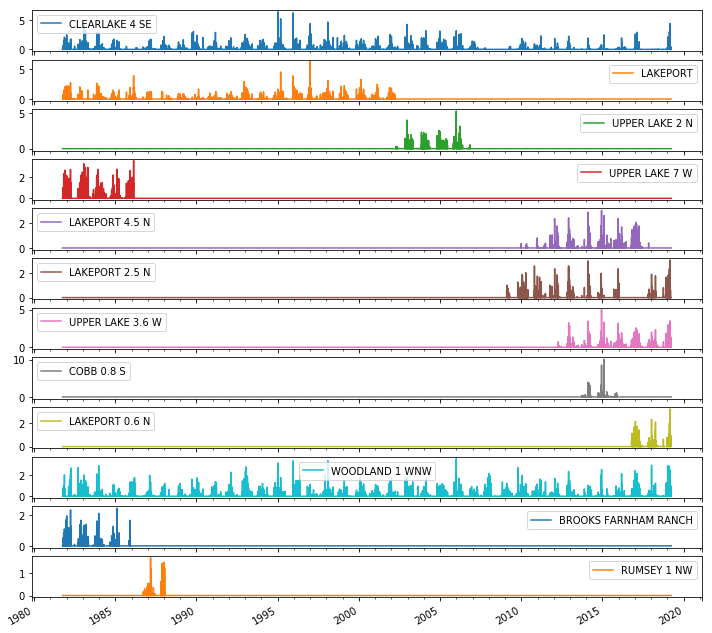

In [12]:
#replace text values so they can be plotted
p.replace(to_replace = ['M','T','S','A'], value=0, regex=True, inplace=True)
p.plot(subplots=True, figsize=(12,12)) 

In [13]:
#the ones to use
mygauges = ['CLEARLAKE 4 SE', 'WOODLAND 1 WNW','LAKEPORT']
#p is the actual precip data
p= p[mygauges]
#basic stations dataframe for mapping etc.
pstations = pd.DataFrame([[y for y in x] for x in pdata],
columns=['name','codes','county','st','r','a','b','lon','lat','data'])

#filter the pstations dataframe and map these
pstations = pstations.loc[pstations['name'].isin(mygauges)]
m = folium.Map(location=[pstations['lat'].mean(), pstations['lon'].mean()], zoom_start=8, tiles="Stamen Terrain")
for i in range(0,len(pstations)):
    tooltip = pstations.iloc[i]['name']
    folium.Marker([pstations.iloc[i]['lat'], pstations.iloc[i]['lon']],tooltip=tooltip).add_to(m)
m

In [15]:
#GROUPING
#by California water year, ending in SEP
# pgroup1 = p.groupby(pd.Grouper(freq='A-SEP')).agg({np.sum})
# by month
months = p.groupby(pd.Grouper(freq='M')).agg({np.sum})
#filter by DEC-MAR
months = months[months.index.month.isin([12,1,2,3])]
#now sum this annually ending in MAR
winterp = months.groupby(pd.Grouper(freq='A-MAR')).agg({np.sum})
#get top level column heads to replace multi-indexed columns
winterp.columns = mygauges

## Precip from CHIRPS via Earth Engine
download csv

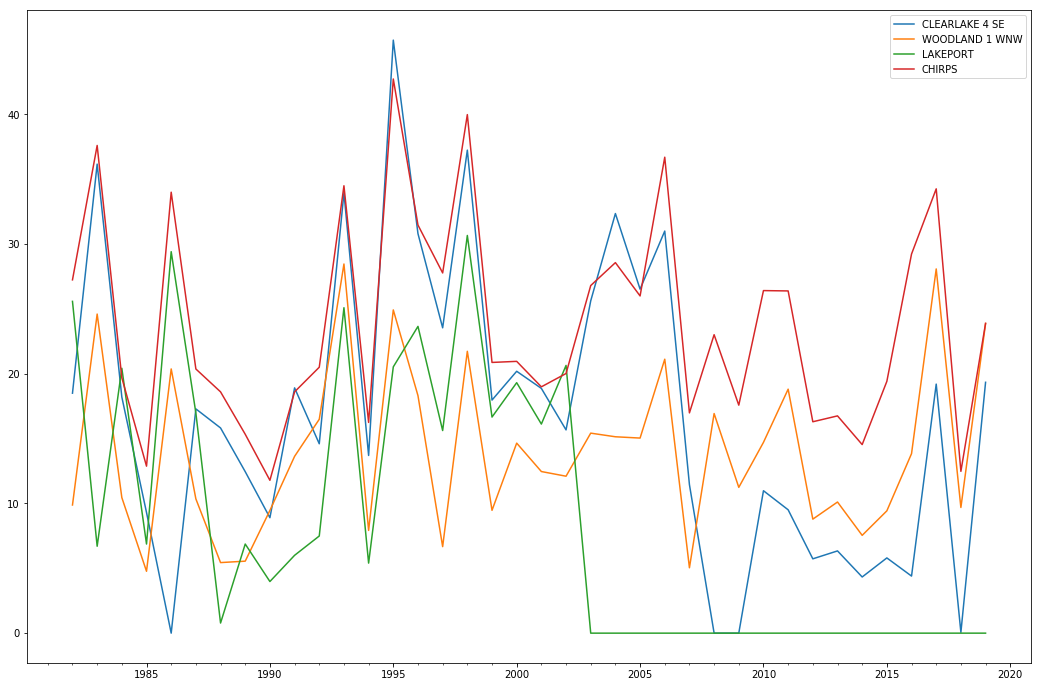

In [16]:
#for Upper Cache huc8
area = 745683.03

#CHIRPS rainfall aggregated by DEC-MAR
chirps = pd.read_csv('C:/Users/Peter/Downloads/winter_rainfallA.csv')
chirps = chirps.transpose()
chirps.drop(chirps.tail(1).index,inplace=True)
chirps.drop(chirps.head(1).index,inplace=True)
chirps['CHIRPS'] = (chirps[0])/(25.4)

#create datetimeindex ending on mar 31
marches = pd.date_range(start=pd.datetime(1982, 3, 31), periods=38, freq='A-MAR')

chirps = chirps.set_index(marches)
chirps = chirps.drop(0, axis=1)
# now we have the same index as winterp
merged = winterp.merge(chirps, left_index=True, right_index=True)
merged.plot(figsize=(18,12))

In [17]:
df=merged.merge(winterflows, left_index=True, right_index=True)

In [18]:
df['Acre-feet Dec-Mar precip from CHIRPS'] = (df['CHIRPS']*area)/12
df['Acre-feet Dec-Mar discharge at Yolo'] = df['Yolo']*((60*60*24)/(208*208))
df['Runoff ratio'] = df['Acre-feet Dec-Mar discharge at Yolo']/df['Acre-feet Dec-Mar precip from CHIRPS']
df.to_csv('UpperCacheCreekWinterRunoffRatios.csv', index=False)

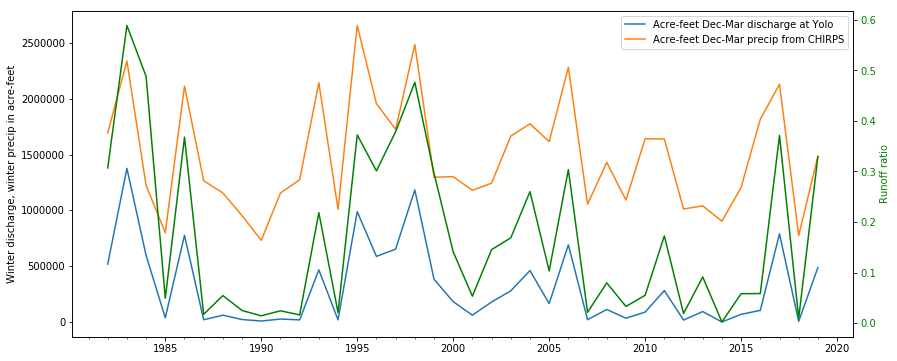

In [20]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# the ax keyword sets the axis that the data frame plots to
# color='b'
df.plot(ax=ax1, y=['Acre-feet Dec-Mar discharge at Yolo','Acre-feet Dec-Mar precip from CHIRPS'], legend=True)
ax1.set_ylabel('Winter discharge, winter precip in acre-feet')
# for tl in ax1.get_yticklabels():
#     tl.set_color(color)

color='g'
ax2.set_ylabel('Runoff ratio', color=color)
df.plot(ax=ax2, y='Runoff ratio', legend=False, color=color)
for tl in ax2.get_yticklabels():
    tl.set_color(color)
plt.savefig('uppercacheRunoffRatios.png')
plt.show()